In [37]:
import sys
sys.path.append('..')

# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3D import
import tidy3d as td
from pepper import SimulationFdfd, PlaneWaveFdfd, GaussianBeamFdfd

In [38]:
# define geometry
wg_width = 0.25
couple_width = 0.05
ring_radius = 3.5
ring_wg_width = 0.25
wg_spacing = 2.0
buffer = 2.0

# # compute quantities based on geometry parameters
# x_span = 2*wg_spacing + 2*ring_radius + 2*buffer
# y_span = 2*ring_radius + 2*ring_wg_width + wg_width + couple_width + 2*buffer
# wg_insert_x = ring_radius + wg_spacing
# wg_center_y = ring_radius + ring_wg_width/2. + couple_width + wg_width/2.
# compute quantities based on geometry parameters
x_span = 2*wg_spacing + buffer
y_span = ring_radius + buffer
wg_insert_x = wg_spacing
wg_center_y = 0#ring_radius + couple_width + wg_width/2.

In [39]:
# wavelength range of interest
lambda_beg = 0.4
lambda_end = 0.6

# define pulse parameters
freq_beg = td.C_0 / lambda_end
freq_end = td.C_0 / lambda_beg
freq0 = (freq_beg + freq_end) / 2
fwidth = (freq_end - freq0) / 1.5

min_steps_per_wvl = 30
run_time = 1e-11

In [40]:
n_bg = 1.0
n_solid = 1.5
background = td.Medium(permittivity=n_bg**2)
solid = td.Medium(permittivity=n_solid**2)

In [41]:
# background of entire domain (set explicitly as a box)
background_box = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[td.inf, td.inf, td.inf],
    ),
    medium=background,
    name='background')

# waveguide
waveguide = td.Structure(
    geometry=td.Box(
        center=[0, wg_center_y, 0],
        size=[td.inf, wg_width, td.inf],
    ),
    medium=solid,
    name='waveguide')

In [42]:
# x_span *= 3
# y_span *= 3

pw_fdfd = GaussianBeamFdfd(
    size=[td.inf,0,td.inf],
    center=(0, -y_span/4, 0),
    wavelength=1.55*1e-6,
    angle_theta=np.pi/4,
    angle_phi=0.0,
    direction='+',
    waist_radius=1.,
)

gauss_fdfd = GaussianBeamFdfd(
    size=[0, 2 , 1],
    center=(-x_span/4, 0, 0.1),
    angle_theta=0.3,
    angle_phi=0.0,
    direction='+',
    wavelength=1.55*1e-6,
)

bloch_x = td.Boundary.bloch_from_source(
    pw_fdfd,
    domain_size=x_span,
    axis=0)

sim_pw_fdfd = SimulationFdfd(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.uniform(dl=x_span / 200),
    # structures=[background_box, waveguide],
    structures=[background_box],
    sources=[pw_fdfd],
    polarization='TE',
    #monitors=[field_monitor, mode_monitor],
    #run_time = 1,
    # boundary_spec=td.BoundarySpec(x=bloch_x, y=td.Boundary.pml(), z=td.Boundary.periodic()),
    boundary_spec=td.BoundarySpec(x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.periodic()),
    tfsf=False
)


sim_fdfd = SimulationFdfd(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.uniform(dl=x_span / 200),
    # structures=[background_box, waveguide],
    structures=[background_box],
    sources=[gauss_fdfd],
    polarization='TE',
    #monitors=[field_monitor, mode_monitor],
    #run_time = 1,
    # boundary_spec=td.BoundarySpec(x=bloch_x, y=td.Boundary.pml(), z=td.Boundary.periodic()),
    boundary_spec=td.BoundarySpec(x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.periodic()),
    tfsf=True
)

In [43]:
sim_fdfd.grid_spec

GridSpec(grid_x=UniformGrid(type='UniformGrid', dl=0.03), grid_y=UniformGrid(type='UniformGrid', dl=0.03), grid_z=UniformGrid(type='UniformGrid', dl=0.03), wavelength=None, override_structures=(), type='GridSpec')

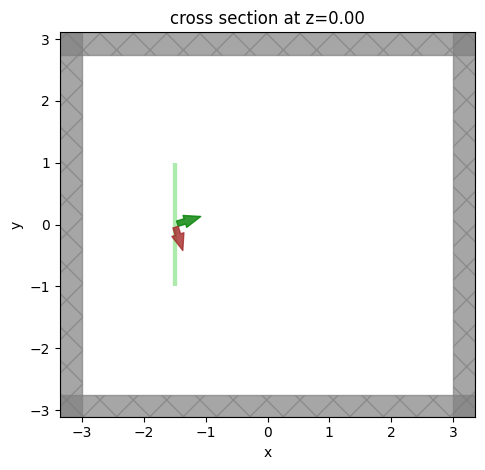

In [44]:
sim_fdfd.plot(z=0);

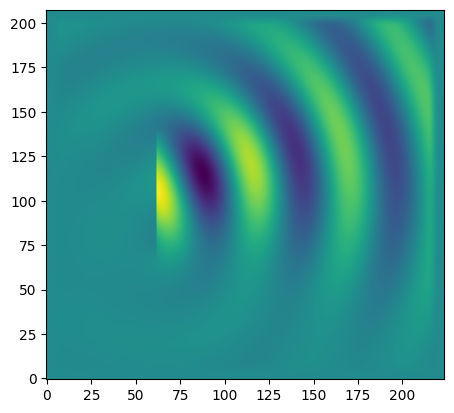

In [45]:
plt.imshow(np.real(sim_fdfd.run()).T, origin='lower');

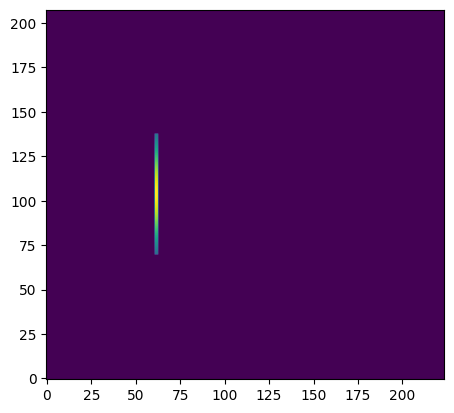

In [46]:
plt.imshow(np.abs(sim_fdfd.source[0].reshape(sim_fdfd.grid.num_cells).squeeze()).T, origin='lower');

In [47]:
pw_fdfd2 = PlaneWaveFdfd(
    size=[0, td.inf ,td.inf],
    center=(-x_span/4, 0, 0),
    wavelength=1.55*1e-6,
    angle_theta=0.3,
    angle_phi=0.0,
    direction='+',
)

bloch_y = td.Boundary.bloch_from_source(
    pw_fdfd2,
    domain_size=y_span,
    axis=1)

sim_fdfd2 = SimulationFdfd(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.uniform(dl=x_span / 200),
    # structures=[background_box, waveguide],
    structures=[background_box],
    sources=[pw_fdfd2],
    polarization='TE',
    #monitors=[field_monitor, mode_monitor],
    #run_time = 1,
    tfsf = True,
    boundary_spec=td.BoundarySpec(x=td.Boundary.pml(), y=bloch_y, z=td.Boundary.periodic()),
)

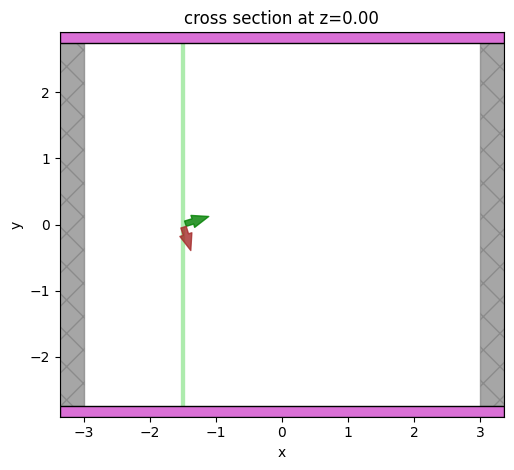

In [48]:
sim_fdfd2.plot(z=0);

In [49]:
gauss = td.GaussianBeam(
    size=[0, 2 , 1],
    source_time=td.GaussianPulse(freq0=sim_fdfd.freq0, fwidth=0.1*sim_fdfd.freq0),
    center=(-x_span/4, 0, 0.1),
    angle_theta=0.3,
    angle_phi=0.0,
    direction='+',
)

bloch_y = td.Boundary.bloch_from_source(
    pw_fdfd2,
    domain_size=y_span,
    axis=1)

sim3d = td.Simulation(
    size=[x_span, y_span, 2],
    grid_spec=td.GridSpec.uniform(dl=x_span / 200),
    # structures=[background_box, waveguide],
    structures=[background_box],
    sources=[gauss],
    #monitors=[field_monitor, mode_monitor],
    run_time = 1,
    boundary_spec=td.BoundarySpec(x=td.Boundary.pml(), y=bloch_y, z=td.Boundary.periodic()),
)

sim2d = td.Simulation(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.uniform(dl=x_span / 200),
    # structures=[background_box, waveguide],
    structures=[background_box],
    sources=[gauss],
    #monitors=[field_monitor, mode_monitor],
    run_time = 1,
    boundary_spec=td.BoundarySpec(x=td.Boundary.pml(), y=bloch_y, z=td.Boundary.periodic()),
)

<Axes: title={'center': 'cross section at z=0.00'}, xlabel='x', ylabel='y'>

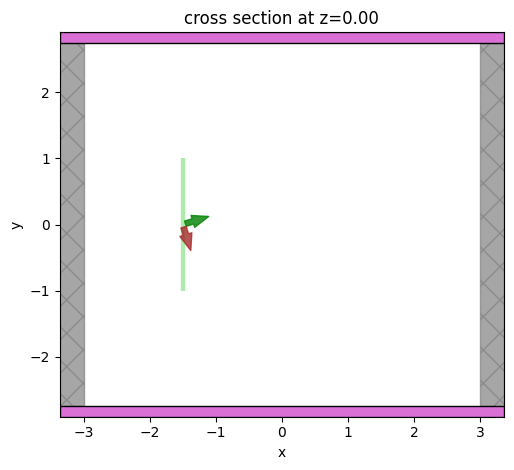

In [50]:
sim3d.plot(z=0)

<Axes: title={'center': 'cross section at y=0.00'}, xlabel='x', ylabel='z'>

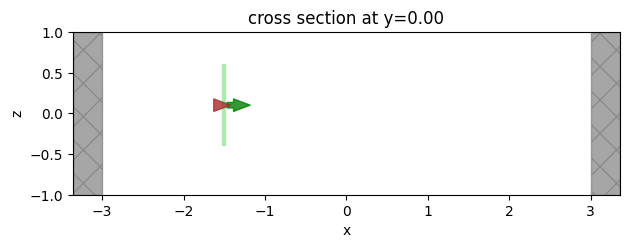

In [51]:
sim3d.plot(y=0)

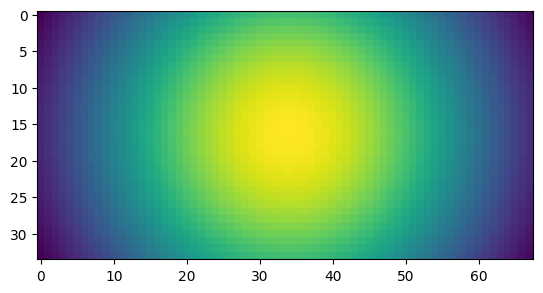

In [52]:
_, coords = gauss.pop_axis(sim3d.discretize(gauss).yee.E.z.to_list, axis=gauss.injection_axis)
_, center = gauss.pop_axis(gauss.center, axis=gauss.injection_axis)

coords = [coords[i] - center[i] for i in range(len(center))]

ii, jj = np.meshgrid(*coords)
plt.imshow(np.exp(-ii**2 - jj**2));

(68, 1) (1, 68, 1) (68,)


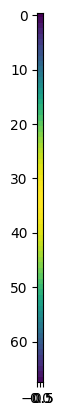

In [65]:
_, coords = gauss.pop_axis(sim2d.discretize(gauss).yee.E.z.to_list, axis=gauss.injection_axis)
_, center = gauss.pop_axis(gauss.center, axis=gauss.injection_axis)

coords = [coords[i] - center[i] for i in range(len(center))]

ii, jj = np.meshgrid(*coords, indexing='ij')
beam = np.exp(-ii**2 - jj**2)
plt.imshow(beam);

src_value = np.zeros(sim2d.grid.num_cells)

indices = [np.arange(*val) for val in sim2d.grid.discretize_inds(gauss)]
src_value[np.ix_(*indices)] = beam

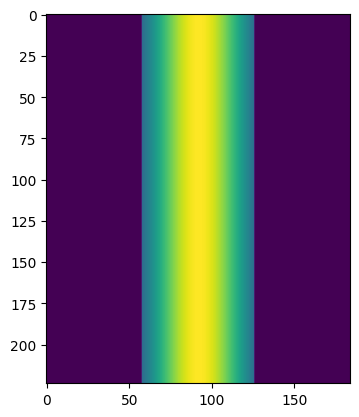

In [67]:
num_cell, num_cells_src = gauss.pop_axis(sim2d.grid.num_cells, axis=gauss.injection_axis)

# src2d = np.moveaxis(np.stack([beam] * num_cell), source=0, destination=gauss.injection_axis)
# src3d = np.moveaxis(np.stack([src_slice] * num_cell), source=0, destination=gauss.injection_axis)

src_slice = np.zeros(num_cells_src)
src_slice[np.ix_(*[np.arange(*val) for val in gauss.pop_axis(sim2d.grid.discretize_inds(gauss), axis=gauss.injection_axis)[1]])] = beam
src2d = np.moveaxis(np.stack([src_slice] * num_cell), source=0, destination=gauss.injection_axis)

plt.imshow(src2d);

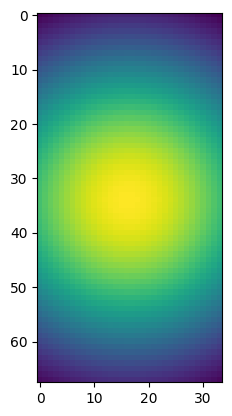

In [69]:
_, coords = gauss.pop_axis(sim3d.discretize(gauss).yee.E.z.to_list, axis=gauss.injection_axis)
_, center = gauss.pop_axis(gauss.center, axis=gauss.injection_axis)

coords = [coords[i] - center[i] for i in range(len(center))]
ii, jj = np.meshgrid(*coords, indexing='ij')
beam = np.exp(-ii**2 - jj**2)
plt.imshow(beam);

# print(np.atleast_3d(beam).shape)
# beam = np.moveaxis(np.atleast_3d(beam), source=0, destination=gauss.injection_axis)
# print(beam.shape)

src_value = np.zeros(sim3d.grid.num_cells)

indices = [np.arange(*val) for val in sim3d.grid.discretize_inds(gauss)]
src_value[np.ix_(*indices)] = beam

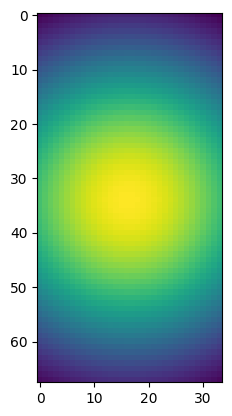

In [77]:
plt.imshow(src_value[np.ix_(*[np.arange(*val) for val in sim3d.grid.discretize_inds(gauss)])].squeeze());